# AC221 Project Final Report
## Evaluating Algorithmic Fairness on the NYPD Stop, Question and Frisk Dataset

Phoebe Wong and Abhimanyu Vasishth

## Background

The use of algorithmic techniques in law-enforcement and other socio-economic settings is now increasingly widespread. Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) scores are used by U.S. courts in order to evaluate the likelihood of recidivism [1]. A new rule applied to the Commercial Division courts of New York encourages the use of Machine Learning and Technology-Assisted Review among litigants in matters pertaining to document review and production [2]. The idea of predictive policing, where Machine Learning or other algorithmic techniques are applied to identify police officers at risk for potential adverse actions, has been proposed with the Charlotte-Mecklenburg Police Department (CMPD) [3] and the Los Angeles Police Department (LAPD) [4] among others. Finally, there are several other algorithmic techniques applied to problems such as loan approval, tax auditing and in the denial and approval of immigration visas. 

This increased usage of algorithmic techniques in law-enforcement raises an important question. Are these algorithms fair? Experts have proposed numerous different, sometimes contradictory, definitions of fairness such as equality of opportunity or social justice and objectively measuring these measures can be hard. Therefore, creating statistical measures of fairness is of paramount importance in order to quantify potential biases in datasets or models.  Using these and other statistical measures of bias can help understand the extent to which existing systems are fair, and existing research includes work using the COMPAS dataset [5,6]. These statistical measures for fairness and bias add checks and balances on models currently deployed in law-enforcement and may help to suggest corrective courses of action if potential sources of bias are found. Promising work has been done to debias image [7] and text [8,9] data. We outline some of the important fairness metrics in the ‘Fairness and Interpretability Metrics’ section.

Not all law-enforcement agents that use algorithms such as COMPAS are Machine Learning experts. Therefore, models used in production should also aim to provide interpretability. In predictive settings, why did a model make a particular prediction? What are the features of the data that led to a particular prediction being made? Since these algorithms often make decisions about humans, they may need to provide explanations to the parties affected. This motivates the importance of techniques facilitating local interpretability: providing feedback or explanations about decisions made on a per-individual basis. To this end, measures such as the Shapley Additive explanation (SHAP) value [10] and packages can be used to demystify predictions from a “black-box” model.

## Motivation

The aim of this project is to study different definitions of fairness on a dataset about human decision making that lends itself to implicit biases (such as biases pertaining to race or gender) or to models that may violate one or many definitions of fairness. To this end, we use the Stop, Question and Frisk dataset from the New York Police Department (NYPD). Given that numerous police departments are already utilizing algorithms for predictive policing, it is not unreasonable to imagine the NYPD leveraging algorithmic models to identify the risk factor for suspects they stop in determining whether or not to arrest them. Specifically, we aim to build a model that has a high classification accuracy on whether a person who was stopped, questioned and frisked was arrested or not and then evaluate this model using notions of fairness such as statistical parity and conditional parity, and also evaluate the decision making process of the model based on feature importances and discuss the applicability of important features in a real-world setting, i.e. if the NYPD deployed an algorithmic solution towards assessing the risk percentages of suspects stopped and using these risk scores to determine whether a suspect should be arrested or not. Furthermore, we aim to provide local interpretability through SHAP values and understand potential solutions to dealing with biased data.

## Related Work

## Data


We used the dataset from NYPD Stop, Question and Frisk (SQF) Dataset from 2018. There are 11008 observations and 70% not-arrested. We define our response variable of whether a person stopped was arrested or not, which therefore, it is a binary response variable.

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import utils
import plotting_utils

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
sqf_df = pd.read_csv('../data/sqf-2018.csv')
sqf_df.head()

,STOP_FRISK_ID,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SEARCH_BASIS_OTHER_FLAG,SEARCH_BASIS_OUTLINE_FLAG,DEMEANOR_CODE,DEMEANOR_OF_PERSON_STOPPED,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_PREMISES_NAME,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,(null),P,PSB,0,MENACING,18,Y,(null),Y,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,COOPERATIVE,(null),MALE,WHITE,5.1,170,MED,BRO,BLK,(null),1,G,(null),VARICK STREET && FRANKLIN STREET,(null),VARICK STREET,982327,201274,(null),PBMS,MANHATTAN
1,2,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,CPW,15,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),DE,NERVOUS,26,MALE,BLACK HISPANIC,6.1,250,HEA,BRO,BLK,(null),34,C,(null),DYCKMAN STREET && POST AVENUE,(null),DYCKMAN STREET,1004892,253548,(null),PBMN,MANHATTAN
2,3,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,GRAND LARCENY,10,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,RELIEVED,40,MALE,WHITE HISPANIC,5.5,150,THN,BRO,BLD,(null),43,B,4M,2245 RANDALL AVENUE,(null),RANDALL AVENUE,1026706,237776,(null),PBBX,BRONX
3,4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,ROBBERY,15,Y,(null),Y,Y,ROBBERY,N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),(null),(null),(null),(null),Y,Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),Y,(null),DE,COMPLAIN,38,MALE,AMERICAN INDIAN/ALASKAN NATIVE,5.1,

In [4]:
clean_sqf_df = utils.data_cleaning_pipeline(sqf_df)
clean_sqf_df.head()

Cleaned dataframe shape: (11008, 111)


,STOP_FRISK_DATE,Stop Frisk Time,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,...,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC,AUTO STRIPPIG,BURGLARY,CPSP,CPW,CRIMINAL MISCHIEF,CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,CRIMINAL POSSESSION OF FORGED INSTRUMENT,CRIMINAL POSSESSION OF MARIHUANA,CRIMINAL SALE OF CONTROLLED SUBSTANCE,CRIMINAL SALE OF MARIHUANA,CRIMINAL TRESPASS,FORCIBLE TOUCHING,GRAND LARCENY,GRAND LARCENY AUTO,MAKING GRAFFITI,MENACING,MURDER,OTHER,PETIT LARCENY,PROSTITUTION,RAPE,RECKLESS ENDANGERMENT,ROBBERY,TERRORISM,THEFT OF SERVICES,UNAUTHORIZED USE OF A VEHICLE,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,1/1/18,19:04:00,0,0,0,POM,1,SGT,1,Y,NaN,P,PSB,0,18,1,NaN,1,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,...,61,170,MED,BRO,BLK,NaN,1,G,NaN,VARICK STREET && FRANKLIN STREET,VARICK STREET,982327,201274,NaN,PBMS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1/1/18,23:00:00,0,0,1,POM,34,SGT,34,N,O,P,PSB,1,15,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,73,250,HEA,BRO,BLK,NaN,34,C,NaN,DYCKMAN STREET && POST AVENUE,DYCKMAN STREET,1004892,253548,NaN,PBMN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1/1/18,23:55:00,0,0,1,POM,808,SGT,808,Y,I,H,Housing,0,10,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,...,65,150,THN,BRO,BLD,NaN,43,B,4M,2245 RANDALL AVENUE,RANDALL AVENUE,1026706,237776,NaN,PBBX,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/1/18,3:23:00,0,0,1,POM,63,SGT,63,Y,O,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,...,61,160,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1/1/18,3:23:00,0,0,1,POM,63,SGT,63,Y,NaN,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,...,71,230,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


## Data Cleaning and Preprocessing

We preprocessed the dataset before any analysis, specifically, the steps taken to clean and preprocess the data are listed below: 

1. Drop extraneous variables: these are variables that are either entirely missing or are redundant (e.g. all the data is from the year 2018). Specifically, the list of variables dropped is [`STOP LOCATION PREMISES NAME`, `STOP FRISK ID`, `YEAR2` and `RECORD STATUS CODE`].
2. Convert hidden missing values to explicit missing values: the dataset encodes missing values using ‘(null)’ as opposed to explicitly marking them as missing. This step involves converting these values to missing values using the package `numpy`, which denotes missing values as `numpy.nan`. 
3. Convert boolean variables with string encoding to 0s and 1s: many of the variables in the dataset are binary (such as ‘PHYSICAL FORCE RESTRAINT USED FLAG’ or ‘BACKROUND CIRCUMSTANCES SUSPECT KNOWN TO CARRY WEAPON FLAG’), however they are not explicitly encoded as such. Specifically, these are often encoded as ‘Y’ and ‘N’ and this step involves converting these encodings to binary variables explicitly so that our modeling process can use these features. 
4. Repeat step 3 for ‘SUSPECT SEX’: we repeat the above step for the ‘SUSPECT SEX’ feature, which encodes values as ‘MALE’ and ‘FEMALE’.
5. Convert date/time to integers: we move from a string representation of the month of the year and the day of the week and convert it to integers (e.g. January is 0, February is 1 and so on).
6. Convert ‘SUSPECT_HEIGHT’ to inches
7. One-hot variables: For the variables ‘SUSPECT RACE DESCRIPTION', ‘SUSPECTED CRIME DESCRIPTION’ and ‘STOP LOCATION BORO NAME’ we one-hot these features. Let us take ‘STOP LOCATION BORO NAME’ as an example. For each of the boroughs (Bronx, Manhattan, Queens, Brooklyn and Staten Island), we create a new binary column (i.e a Queens row has 1 in the Queens column and 0 for all the other columns).


## Exploratory Data Analysis

The figure below illustrates a class imbalance in our response variable. One approach could be to adjust the weights of the classes in our modeling phase to explicitly account for this class imbalance. The problem with such a class imbalance is that a baseline model that simply predicts Not Arrested for every suspect has an accuracy of 71.7%!

![alt](../viz/baseline_pie.png) 

We looked at the distribution of stop and frisk incidents by month, race and gender. We looked at the distribution between months to see if it resembles any seasonal pattern that observed in actual crime rate. 

We compared the count between race and gender, because gender and race are defined as protected class legally. To evaluate our model fairness, particularly on the protected class, we want to know if there is any baseline difference.

Figure 1a: \# of Stopped by Month | Figure 1b: \# of Stopped and Arrested by Month
- | - 
![alt](../viz/month2.png) | ![alt](../viz/month_sep.png)

From Figure 1a, we can see that there's some variation in number of suspects stopped between months, particularly, we can note that November and December has lower numbers than others. From Figure 1b, we can see that there are some variation in both number of arrests and stopped between months.

Figure 2a: \# of Stopped by Race | Figure 2b: \# of Stopped and Arrested by Race
- | - 
![alt](../viz/race.png) | ![alt](../viz/race2.png)

From Figure 2a, we can see that Black has the highest count among the suspects stopped, however, we can see that there is a small variation of the ratio (23-29%) of count of arrested over count of stopped between each race, suggested by Figure 2b. White Hispanic suspects are arrested at a slightly higher rate. This could perhaps reflect a potential source of bias in the dataset and our modeling process should assess whether the algorithm is biased as a result of a potentially biased set of training inputs. We can then decide on a corrective course of action to perhaps mitigate this source of bias if the magnitude of difference between races had been larger.



Figure 3a: \# of Stopped by Gender | Figure 3b: \# of Stopped and Arrested by Gender
- | - 
![alt](../viz/gender.png) | ![alt](../viz/gender2.png)

From Figure 3a, we can see that male has the highest count among the suspects stopped, however, we can see that the difference is a lot smaller when comparing the ratio of count of arrested over count of stopped between each gender, suggested by Figure 2b. Null indicates missing self-report gender.

Figure 4a: \# of Stopped by Age | Figure 4b: \# of Stopped and Arrested by Age
- | - 
![alt](../viz/age.png) | ![alt](../viz/age2.png)

From Figure 4a, we can see that most people who are stopped are among age 15-25, and from Figure 4b, we can see the pattern are similar between stopped only and stopped and arrested. However, we can see that proportionally, the ratio of arrest to stopped only is much higher when the suspect is older.

## Modeling

The response variable we use is ‘SUSPECT ARRESTED FLAG’, which is a binary flag denoting whether the suspect has been arrested or not. Since we know that about 70% of suspects are not arrested, we perform class balancing in our modeling process.

The dataset contains numerous binary variables (such as ‘PHYSICAL FORCE RESTRAINT USED FLAG’ or ‘BACKROUND CIRCUMSTANCES SUSPECT KNOWN TO CARRY WEAPON FLAG’) means that a tree-based model is better suited to the data. To this end, we employ two models in our modeling process: 

1. Random Forest Model: Random Forests are an ensemble model that build on top of decision trees. Multiple decision trees are employed to this classification problem and the output is the mode of the predictions made by all the individual trees. However, unlike other ensembles of decision trees (such as bagging models), Random Forests are less prone to overfitting as each ‘split’ uses a random subset of features. Bagging models uses trees that split on the same set of features, which results in highly correlated trees and in turn overfits to the data. 

2. AdaBoost Model: AdaBoost also are ensembles of decision trees. Specifically, the algorithm builds on top of "weak learners", which are decision trees of shallow depth. The output of these weak learners is combined into a weighted sum that is output by this model.

3. Logistic Regression: This is a widely used classification algorithm that is a generalized extension of linear regression. 


### Creating the training and test datasets

In [6]:
model_df = utils.get_X_y(clean_sqf_df)
X, y = utils.get_X_y(clean_sqf_df)

# Full dataset
X_train_fu, X_test_fu, y_train_fu, y_test_fu = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train_fu.shape, X_test_fu.shape, y_train_fu.shape, y_test_fu.shape)

(7329, 83) (3610, 83) (7329,) (3610,)


### Full Models (with Adjusted Class Weights)

#### Model 1: Full Random Forest Model

Training accuracy of Model 1: 80.8705143948697%
Test accuracy of Model 1: 81.38504155124654%


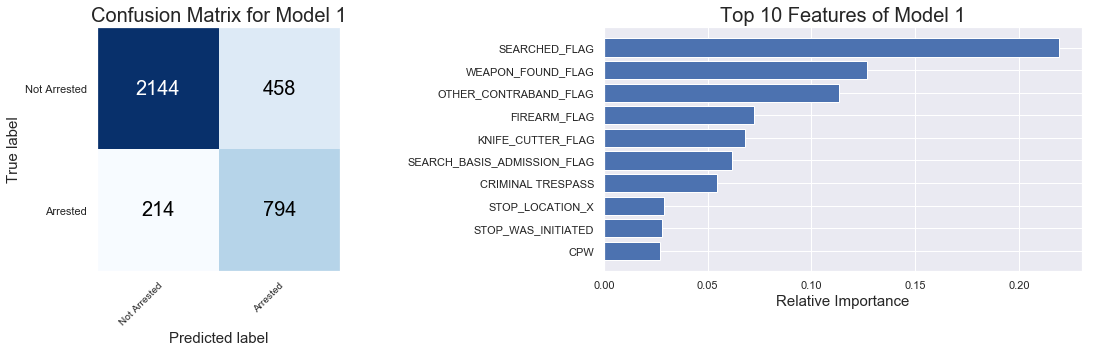

In [7]:
model_1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight='balanced')
model_1 = model_1.fit(X_train_fu, y_train_fu)
name = 'Model 1'
model = model_1

print('Training accuracy of {}: {}%'.format(name,100*model.score(X_train_fu, y_train_fu)))
print('Test accuracy of {}: {}%'.format(name,100*model.score(X_test_fu, y_test_fu)))

# Plotting confusion matrix and feature importances
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.ravel()
y_true = y_test_fu
y_pred = model.predict(X_test_fu)
plotting_utils.plot_cm(y_true, y_pred, ['Not Arrested', 'Arrested'], name, ax[0]);

plotting_utils.plot_feature_imp(X_test_fu, model, name, ax[1], 10)
fig.tight_layout()

After using balanced class weights to adjust for the fact that about 70% of suspects do not get arrested, the confusion matrix looks fair. However, one interesting observation is that the number of false positives are more than twice the number of false negatives. The feature importances illustrates an issue. One of the top 10 features is STOP_LOCATION_X. This means that if such a model was deployed, one of the important features determining whether a suspect was arrested or not is the location the suspect is stopped at. Since the location could be correlated with socio-economic variables such as income or race, this could be a potential source of unfairness in the model. Therefore, the next iteration of our Random Forest model involves removing features such as this.

#### Model 2: Full AdaBoost Model

Training accuracy of Model 2: 88.41588211215719%
Test accuracy of Model 2: 89.47368421052632%


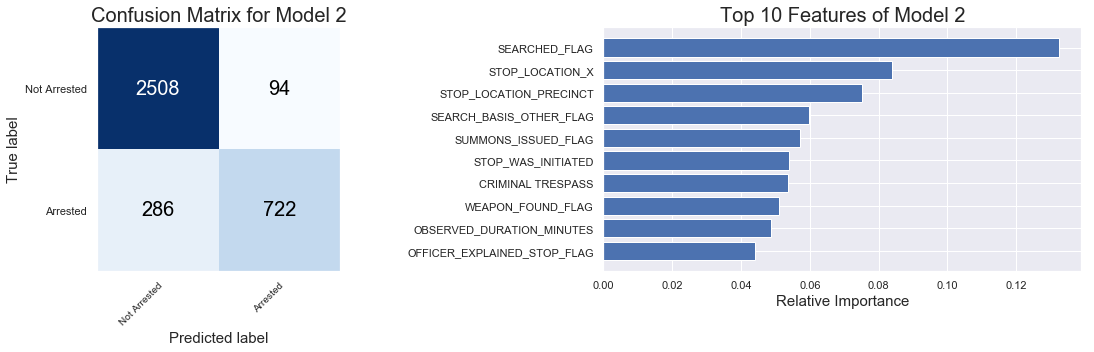

In [8]:
base = DecisionTreeClassifier(max_depth=2)
model_2 = AdaBoostClassifier(n_estimators=10, base_estimator=base).fit(X_train_fu, y_train_fu)
name = 'Model 2'
model = model_2

print('Training accuracy of {}: {}%'.format(name,100*model.score(X_train_fu, y_train_fu)))
print('Test accuracy of {}: {}%'.format(name,100*model.score(X_test_fu, y_test_fu)))

# Plotting confusion matrix and feature importances
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.ravel()
y_true = y_test_fu
y_pred = model.predict(X_test_fu)
plotting_utils.plot_cm(y_true, y_pred, ['Not Arrested', 'Arrested'], name, ax[0]);

plotting_utils.plot_feature_imp(X_test_fu, model, name, ax[1], 10)
fig.tight_layout()

The confusion matrix for the AdaBoost model is better: we are able to distinguish between the two classes better and have significantly fewer false positives. However, some of the important variables are still problematic. Both the STOP_LOCATION_X and the STOP_LOCATION_PRECINCT show up, which may again be correlated with various socio-economic factors that we may not want to include if this model was to be deployed in a real-world setting.

#### Model 3: Full Logistic Regression Model

The feature importances for a variable were calculated by dividing the coefficients of the model by the standard deviation of the corresponding column of the training data. The absolute value of the result of this division was taken and normalized to get relative feature importances for all the features in the model.

Training accuracy of Model 3: 86.95592850320644%
Test accuracy of Model 3: 87.28531855955679%


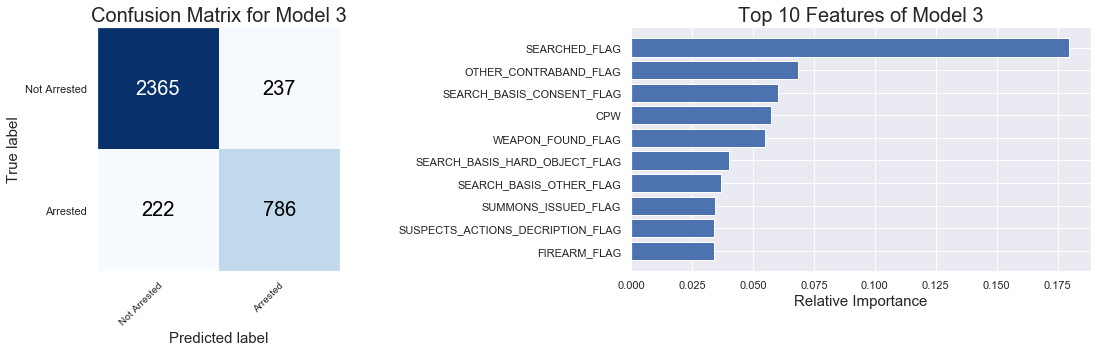

In [9]:
model_3 = LogisticRegression(solver='liblinear', class_weight='balanced')
model_3 = model_3.fit(X_train_fu, y_train_fu)
name = 'Model 3'
model = model_3

print('Training accuracy of {}: {}%'.format(name,100*model.score(X_train_fu, y_train_fu)))
print('Test accuracy of {}: {}%'.format(name,100*model.score(X_test_fu, y_test_fu)))

# Plotting confusion matrix and feature importances
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.ravel()
y_true = y_test_fu
y_pred = model.predict(X_test_fu)
plotting_utils.plot_cm(y_true, y_pred, ['Not Arrested', 'Arrested'], name, ax[0]);

feature_imps = np.abs(np.std(X_train_fu, 0)*model.coef_.flatten())
feature_imps = feature_imps/np.sum(feature_imps)
feature_imps = feature_imps.sort_values(ascending=False)[0:10].sort_values()

ax[1].barh(range(len(feature_imps)), feature_imps.values, color='b', align='center')
ax[1].set_yticks(range(len(feature_imps)))
ax[1].set_yticklabels(feature_imps.index.values)
ax[1].set_xlabel('Relative Importance', fontsize=15)
ax[1].set_title('Top {} Features of {}'.format(10, name), fontsize=20)

fig.tight_layout()

The Logistic Regression model has a fairly equal number of false positives and false negatives. Interestingly, this model does not rely on location or precinct information.

### Removing Sensitive Features from the Dataset

In a real-world setting, we would not want an algorithm to make a prediction based on sensitive features, such as race, gender or zip code, since we would want an ideal algorithm to be blind to these factors when deciding whether or not a person stopped should be arrested or not. To this end, we drop the following variables from our full model:

1. 'WHITE'
2. 'WHITE HISPANIC',
3. 'SUSPECT_SEX',
4. 'STOP_LOCATION_X',
5. 'STOP_LOCATION_Y',
6. 'STOP_LOCATION_PRECINCT',
7. 'STATEN ISLAND',
8. 'QUEENS',
9. 'MONTH2',
10. 'MANHATTAN',
11. 'DAY2',
12. 'BLACK',
13. 'BLACK HISPANIC',
14. 'BROOKLYN',
15. 'ASIAN / PACIFIC ISLANDER',

In [10]:
# Dataset with select columns
X_small = X[utils.usable_cols]
y_small = y
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_small, y_small, test_size=0.33, random_state=42)
print(X_train_sm.shape, X_test_sm.shape, y_train_sm.shape, y_test_sm.shape)

(7329, 67) (3610, 67) (7329,) (3610,)


### Adjusted Models

Models that did not include the sensitive features

#### Model 4: Adjusted Random Forest Model

Training accuracy of Model 4: 80.91144767362533%
Test accuracy of Model 4: 81.49584487534625%


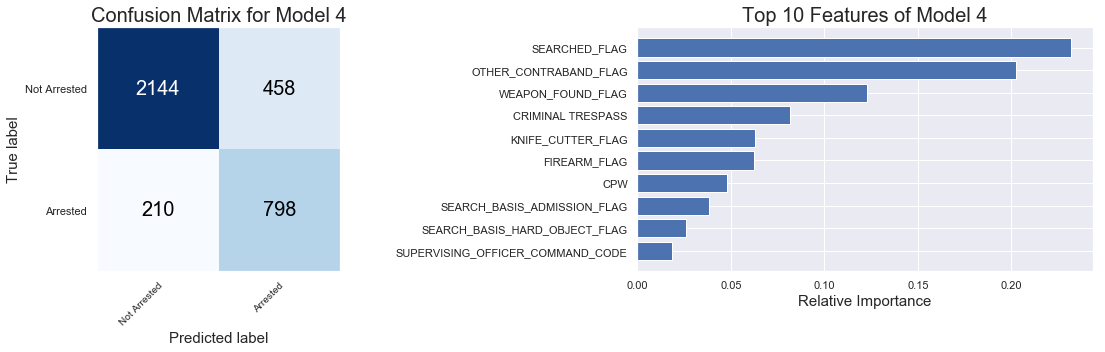

In [11]:
model_4 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, class_weight='balanced')
model_4 = model_4.fit(X_train_sm, y_train_sm)
name = 'Model 4'
model = model_4

print('Training accuracy of {}: {}%'.format(name,100*model.score(X_train_sm, y_train_sm)))
print('Test accuracy of {}: {}%'.format(name,100*model.score(X_test_sm, y_test_sm)))

# Plotting confusion matrix and feature importances
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.ravel()
y_true = y_test_sm
y_pred = model.predict(X_test_sm)
plotting_utils.plot_cm(y_true, y_pred, ['Not Arrested', 'Arrested'], name, ax[0]);

plotting_utils.plot_feature_imp(X_test_sm, model, name, ax[1], 10)
fig.tight_layout()

#### Model 5: Adjusted AdaBoost Model

Training accuracy of Model 5: 88.14299358711966%
Test accuracy of Model 5: 89.22437673130193%


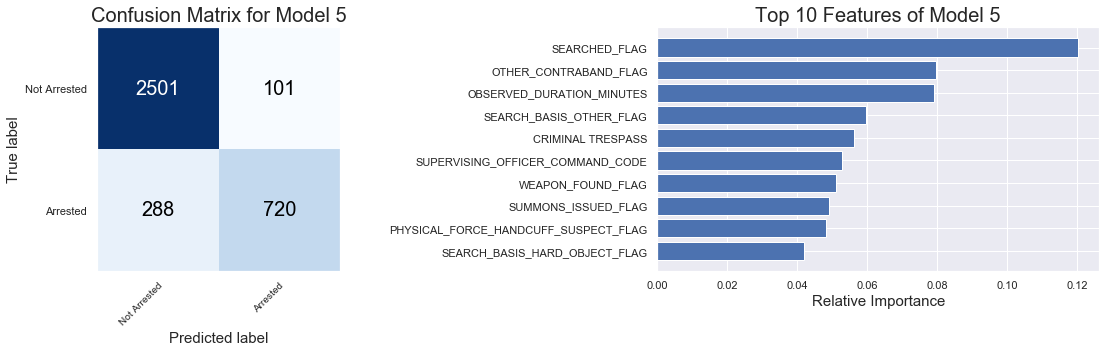

In [12]:
base = DecisionTreeClassifier(max_depth=2)
model_5 = AdaBoostClassifier(n_estimators=10, base_estimator=base).fit(X_train_fu, y_train_fu)
model_5 = model_5.fit(X_train_sm, y_train_sm)
name = 'Model 5'
model = model_5

print('Training accuracy of {}: {}%'.format(name,100*model.score(X_train_sm, y_train_sm)))
print('Test accuracy of {}: {}%'.format(name,100*model.score(X_test_sm, y_test_sm)))

# Plotting confusion matrix and feature importances
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.ravel()
y_true = y_test_sm
y_pred = model.predict(X_test_sm)
plotting_utils.plot_cm(y_true, y_pred, ['Not Arrested', 'Arrested'], name, ax[0]);

plotting_utils.plot_feature_imp(X_test_sm, model, name, ax[1], 10)
fig.tight_layout()

#### Model 6: Adjusted Logistic Regression Model

Training accuracy of Model 6: 86.87406194569517%
Test accuracy of Model 6: 87.25761772853186%


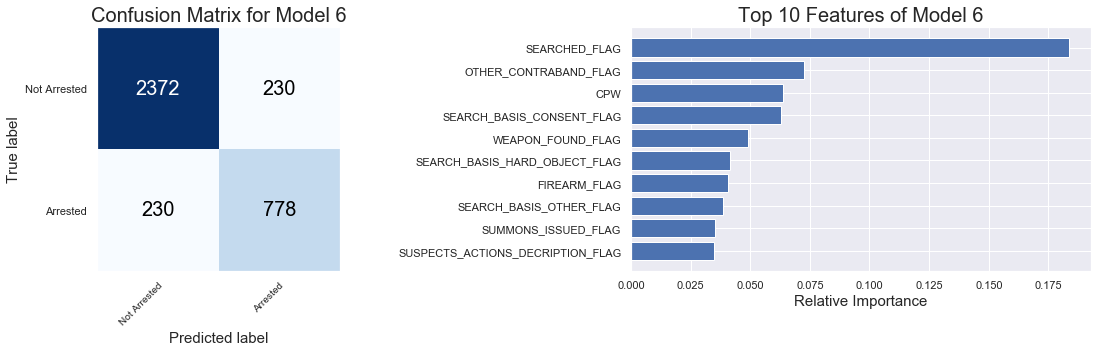

In [13]:
model_6 = LogisticRegression(solver='liblinear', class_weight='balanced')
model_6 = model_6.fit(X_train_sm, y_train_sm)
name = 'Model 6'
model = model_6

print('Training accuracy of {}: {}%'.format(name,100*model.score(X_train_sm, y_train_sm)))
print('Test accuracy of {}: {}%'.format(name,100*model.score(X_test_sm, y_test_sm)))

# Plotting confusion matrix and feature importances
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax = ax.ravel()
y_true = y_test_sm
y_pred = model.predict(X_test_sm)
plotting_utils.plot_cm(y_true, y_pred, ['Not Arrested', 'Arrested'], name, ax[0]);

feature_imps = np.abs(np.std(X_train_sm, 0)*model.coef_.flatten())
feature_imps = feature_imps/np.sum(feature_imps)
feature_imps = feature_imps.sort_values(ascending=False)[0:10].sort_values()

ax[1].barh(range(len(feature_imps)), feature_imps.values, color='b', align='center')
ax[1].set_yticks(range(len(feature_imps)))
ax[1].set_yticklabels(feature_imps.index.values)
ax[1].set_xlabel('Relative Importance', fontsize=15)
ax[1].set_title('Top {} Features of {}'.format(10, name), fontsize=20)

fig.tight_layout()

Interestingly, we obtain a very similar classification accuracy and proportions of true and false positives/negatives for all three adjusted models even though the important features have changed quite significantly. This is encouraging as it means we don't, in this case, sacrifice prediction accuracy over a set of predictors that are not sensitive.

## Fairness and Interpretability Metrics
We explore a few commonly used metrics to evaluate the fairness of our model prediction and the local interpretability of our model.

### Statistical parity
Statistical parity measures the difference between the probability of positive decisions for the protected group and the probability of positive decisions for the unprotected group. Mathematically:
$$Sp = P(d=1|G=0) - P(d=1|G=1)$$

Ideally, $Sp$ should be small such that there is little difference of probability of positive decisionb etween protected and unprotected group. A large value of $Sp$ suggests potential unfairness in the dataset and $Sp$ of 0 suggests complete fairness (equal probability between classes).

In our dataset, we can examine the probability of positive decision (stopped and arrested) between different **gender** and **race**.

In the example of gender, we are comparing the proportion of positive decisions amongst male and substracting the proportion of positive decisions amongst female

$$Sp = \frac{ \text{# positive predictions and male}} { \text{ # of male} } - \frac{ \text{# positive predictions and female}} { \text{ # of female}}$$

### Conditional Parity
Besides Statistical parity, we can further evaluate if there is any difference between classes if we condition the classes on a certain condition, in other words, are we being fair, in terms of statistical parity, in that subgroup? For example, in our dataset, we can consider `race` column as our condition, and evaluate the difference between the two genders when conditioned on race. 

$$\frac{ \text{# positive predictions and black male}} { \text{ # of black male} } - \frac{ \text{# positive predictions and black female}} { \text{ # of black female}}$$

### False Positive (Negative) Error Rate Balance (FPR/FNR)
The two parity measures do not take into account the real labels of each observation; they only consider the predictions. False Positive/Negative Error Rate Balance examines if there are equal poportions of false positives/false negatives in protected and unprotected classes. This is a particularly important metric in cases where committing mistakes disproportionately for different protected groups can bring negative outcomes.

In the example of using gender as the protected class, the definitions are as following:

$FPR = \frac{ \text{# false positive in male}} { \text{ # of male} } - \frac{ \text{# false positive in female}} { \text{ # of female}}$

$FPR = \frac{ \text{# false negative in male}} { \text{ # of male} } - \frac{ \text{# false negative in female}} { \text{ # of female}}$

while false positive is defined as count of cases where the true label is false and the predicted label is true, vice versa for false negative.

### SHAP
SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. It assigns each feature an importance value for a particular prediction. Overall, SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

The range of SHAP values are bounded by the output magnitude range of the model. Because we are predicting probability in our model, the range of SHAP values will be from -1 to 1. 

#### Definition of SHAP value
Mathematically, we can break down the calculation of SHAP value as following:

$f_x(S) = f(h_x(z')) = E[f(x) | x_S]$

1. $z'$ represent a feature being observed ($z_i'$ = 1) or unknown ($z_i'$ = 0)

2. $h_x$ is a mapping that maps between a binary pattern of missing features represented by $z'$ and the original function input space.

Given such mapping, we can evaluate $f(h_x(z'))$ and so calculate the effect of observing ($z_i' = 1$) or not observing a feature ($z_i' = 0$)

3. $S$ refers the set of non-zero indexes in $z'$

4. $E[f(x) | x_S]$ is the expected value of the function conditioned on a subset $S$ of the input features.



SHAP values combine these conditional expectations with the classic Shapley values from game theory to attribute $\phi_i$ values to each feature:

$\phi_i = \sum \frac{|S|!(M-|S|-1)}{M!} [f_x(S \cup \{i\}) - f_x(S)]$

## Results

### Statistical and Conditional Parity
Here's the summary of our four models performance on the parity measures. 


| Metrics                     | Random Forest (Full) | Random Forest (Adjusted) | AdaBoost (Full) | AdaBoost (Adjusted) |
|-----------------------------|----------------------|--------------------------|-----------------|---------------------|
| Statistical Parity (Gender) | .017                 | .011                     | .023            | .004                |
| Statistical Parity (Race)   | .002                 | .003                     | .023            | .001                |
| Conditional Parity          | .004                 | .004                     | .004            | .004                |

### SHAP value
We looked at SHAP value of our Random Forest model from two perspectives. 
1. Overall contribution: we used the mean absolute value of SHAP values for each feature to understand its contribution to the model

2. Individual observation: we looked at the feature contribution to the predicted value, both in magnitude and direction. 

#### Overall contribution

Figure 5a: Overall Feature Contribution in Full Random Forest Model | Figure 5b: Overall Feature Contribution in Adjusted Random Forest Model
- | - 
![alt](../viz/shap_full2.png) | ![alt](../viz/shap_fair2.png)

Looking at Figure 5a, we can see that, in the full model, if the suspect is searched or not (`SEARCHED_FLAG`) is the most important feature to the prediction. The other top features are related to if the suspect carries weapons, which is intuitive to understand the relationship between that and predicted arrest decision. 

Interestingly, after adjusting our model to exclude some confounding variables (gender, race, location and other stopped-related features which one would not have access to before the stop happens), the top important features of the model is very different than those in the full model, in fact, the top features . From Figure 5b, we can see that (`OFFICER_EXPLAINED_STOP_FLAG` and `UNAUTHORIZED USED OF A VEHICLE`) are now the top important features in the model, which were not in the top 20 most important features in the full model. 

Because SHAP value relies on the expected value of the function conditioned on a subset of the input features, the difference in the top important features between the two models suggest that there is some interaction between the excluded features and the important features which then influences the prediction, even though not all excluded features have a high SHAP values in the full model. 

#### Individual observation feature importance

If the model is deployed and used in real-world setting, it is important to interpret what feature drives the predicted probability. 

![alt](../viz/shap_rf_full_class0_i3.png)
Figure 6a: Individual Feature Contribution in Full Random Forest Model 

We are focusing on a single observation and evaluating the decision here.
From Figure 6a, we can see that in the full model, the predicted probability of being in "Not Arrested" is 0.63 where the baseline value is around 0.715. The baseline value here refers to the sample proportion of "Not Arrested", which means 71.5% of our sample is not arrested. 

We can then see how individual features pushed the predicted value to be different than the mean. For example, we can see that the fact that this suspect has no knife cutter nor weapon found pushed the probability of being in "Not Arrested" ($P(\text{(Not Arrest)}$) to be higher (e.g., `KNIFE_CUTTER_FLAG` and `WEAPON_FOUND_FLAG` are both 0). 

Oppositely, we see that the fact that the suspect was searched (e.g., `SEARCHED_FLAG` = 1) pushed the probability of not arrested lower (meaning $P(\text{(Arrest)}$ is higher) 


![alt](../viz/shap_rf_sm_class0_i3.png)
Figure 6b: Individual Feature Contribution in Adjusted Random Forest Model

In the reduced model, we can interpret the feature importance similarly. For example, the fact that the suspect has no unauthorized use of a vehicle pushed $P(\text{(Not Arrest)}$ higher, while the fact that the officer has to explain the stop pushed $P(\text{(Not Arrest)}$ lower, which again means $P(\text{(Arrest)}$ higher.


## Discussion

### Data Dictionary
We obtained the data from the publicly available NYPD dataset, however, it does not come with any data dictionary, which means that we do not have an official definition and understanding of the features in the dataset. We tried our best to interpret the features based on the column names, however, we want to note that there is room for interpretation for some of the features, especially the non-binary values in supposingly binary "FLAG" columns. There are some features that the model could potentially benefit with a higher accuracy if we know the codecook, for example, `STOP_LOCATION_SECTOR_CODE` and having a better understanding of `ISSUING_OFFICER_COMMAND_CODE` might allow us to investigate individual difference.

### SHAP value
SHAP value allows us to assign a metric of importance to each feature, however, if no single feature stands out, i.e., all features importance scores are low in magnitude, then it becomes hard to interpret what the top important feature means, and the "important features" might be too sensitive to individual observation difference. 

For example, in Figure 6b, we see that in our adjusted random forest model, the particular suspect having "PHYSICAL_FORCE_WEAPON_IMPACT_FLAG" as 0 pushes $P(\text{(Not Arrest)}$ lower (= $P(\text{(Arrest)}$ higher), which is not straightforward to understand. We then looked at the distribution of "PHYSICAL_FORCE_WEAPON_IMPACT_FLAG" in our dataset and found out that majority of the observations have a 0, which the feature is then highly biased by the 4 observations with a "1" in the feature.

![alt](../viz/shap_phyforce.png)

As discussed earlier, the range of SHAP values are bounded by the output magnitude range of the model, and in our case, SHAP values can range from -1 to 1. We can therefore conclude that our top important features in both full and adjusted models have very small SHAP values compared to the theortical range it could take on, and therefore, we should use SHAP value cautiously when interpreting the importance. 

One way that we thought about improving interpreting the SHAP value interpretation is to remove features that are highly inbalanced, which then will allow SHAP values to be calculated only on features that are less influenced by individual observations. However, in practice, it is hard to know ahead of time which feature is going to be inbalanced and the police department might want to keep some key features (from their experience) in the model even though it is highly imbalanced, for example, binary indication of rare severe events like `MURDER`. 

## Reference